# Feature Selection

In [1]:
ct = 'pearson' #Correlation Type
tm = 'gce' # Thresholding Method:
           # It could be 'GCE' or 'user_defined'
tv = 0.05  # Thresholding Value, For user defined tm

### Import

In [2]:
from config import *
from src.data import subjects
import numpy as np
import pandas as pd
import glob
from IPython.display import display
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm

### Read Data

In [3]:
all_sub_list = subjects.to_group_level_analysis[0]
all_subjects = subjects.subjects['all'][subjects.subjects['all']['participant_id'].isin(all_sub_list)]

subjects_list = {}
for sg in subjects_groups:
    subjects_list[sg] = all_subjects.where(all_subjects.group==sg).dropna()
    print('\n%d %s subjects are included'%(len(subjects_list[sg]),sg))
    display(subjects_list[sg])
    subjects_list[sg] = subjects_list[sg].participant_id.tolist()


24 CN subjects are included


,group,participant_id,sex,age
0,CN,003S4288,F,78.4
1,CN,011S0021,F,84.9
2,CN,020S6185,M,82.7
3,CN,023S1190,F,87.4
4,CN,035S6160,M,60.7
5,CN,036S6189,F,69.6
6,CN,037S4028,F,70.7
7,CN,041S4200,F,76.4
8,CN,041S6159,M,76.3
9,CN,041S6192,F,83.3



0 EMCI subjects are included


,group,participant_id,sex,age



0 LMCI subjects are included


,group,participant_id,sex,age



24 AD subjects are included


,group,participant_id,sex,age
72,AD,002S5018,M,73.4
73,AD,006S4153,M,81.5
74,AD,006S4867,M,75.7
75,AD,013S5071,M,76.4
76,AD,018S4696,F,73.3
77,AD,018S4733,M,75.4
78,AD,018S5074,F,74.9
79,AD,019S4252,F,86.8
80,AD,019S4477,F,82.4
81,AD,019S4549,M,79.4


In [4]:
str_loc    = ['loc_'  + ds for ds in denoising_strategies]
str_glob   = ['glob_' + ds for ds in denoising_strategies]
strlist    = str_loc.copy()
strlist.extend(str_glob)

In [5]:
if tm=='userdefined':
    tm = '%s-%.3f'%(tm,tv)

In [6]:
norm = ""
if normalize_measures:
    norm="_norm"

directoies = {}
for ds in denoising_strategies:
    dirc = '%s/data/06_network_measures/tm-%s/corr-%s/ds-%s/'%(rootdir,tm,ct,ds)

    lc  = 'loc_'  + ds
    glb = 'glob_' + ds
    directoies[glb]    = glob.glob("%s/*/*global_measures_giant_component.csv"%(dirc))
    directoies[lc] = glob.glob("%s/*/*local_measures_giant_component*%s*.csv"%(dirc,norm))

In [7]:
measures = {}
measures['all'] = {}

for sg in subjects_groups: 
    measures[sg]  = {}

for i in strlist:
    measures['all'][str(i)] = {}
    for sg in subjects_groups: 
        measures[sg][str(i)]  = {}
    for sub in directoies[str(i)]:
        id = str(sub.split("/sub-")[1].split('/sub-')[0]) 
        measures['all'][str(i)][id]    = pd.read_csv(sub, sep='\t')
        measures['all'][str(i)][id]    = measures['all'][str(i)][id].drop(['Unnamed: 0'], axis=1)
        
        for sg in subjects_groups: 

            if id in subjects_list[sg]:
                measures[sg][str(i)][id] = pd.read_csv(sub, sep='\t')
                measures[sg][str(i)][id] = measures[sg][str(i)][id].drop(['Unnamed: 0'], axis=1)

In [8]:
# measures variable structure:
#
#    measures
#    │
#    ├── group 1
#    │   ├── denoising strategie 1- global measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 1- local measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 2- global measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 2- local measures
#    │   │   └── group 1 subjects
#    │   ├── ...
#    │   │
#    │   └── denoising strategie n- local measures
#    │       └── group 1 subjects
#    │   
#    ├── ...
#    │
#    └── last group
#        ├── denoising strategie 1- global measures
#        │   └── last group subjects
#        ├── denoising strategie 1- local measures
#        │   └── last group subjects
#        ├── denoising strategie 2- global measures
#        │   └── last group subjects
#        ├── denoising strategie 2- local measures
#        │   └── last group subjects
#        ├── ...
#        │
#        └── denoising strategie n- local measures
#            └── last group subject

### Finding out nodes that exist in all networks

In [9]:
print('the number of nodes appeared in the giant components of all subjects:\n') 
intersect = {}
for i in str_loc:
    intersect[i] = list(range(360))
for i in str_loc:
    for sub in measures['all'][i]:
        a = measures['all'][i][sub].ID.to_list()
        intersect[i] = list(set(intersect[i]) & set(a))
    name = i.split('loc_')[1]
    print('\t%d out of 360 nodes for networks with %s thresholding method.'
          %(len(intersect[i]),name))

    #removing nodes
    for sub in measures['all'][i]:
        measures['all'][str(i)][sub] = measures['all'][str(i)][sub].loc[measures['all'][str(i)][sub]['ID'].isin(intersect[i])]

the number of nodes appeared in the giant components of all subjects:

	357 out of 360 nodes for networks with 9p thresholding method.
	359 out of 360 nodes for networks with 36p thresholding method.
	359 out of 360 nodes for networks with 36pscrubbed thresholding method.


### Constructing Feature Matrix

It's a N*M matrix, where:

\begin{equation*}
N   =  Number \: of \: Smples; \\
M   =  (Number \: of \: Local \: Measures \: * \: Number \: of \: Nodes) \: + \: Number \: of \: Global \: Measures
\end{equation*}



In [10]:
14*359+10

5036

In [11]:
features = pd.DataFrame({})
s = []
for sub in measures['all']['loc_'+ds]:
    loc  = measures['all']['loc_'+ds][sub].drop(
        columns=['ID']).stack().to_frame()
    glob = measures['all']['glob_'+ds][sub].drop(
        columns=['center', 'periphery'])
    fea  = pd.concat([loc,glob.transpose()],axis=0)
    s.append(sub)
    try:
        features = pd.concat([features,fea],axis=1)
    except NameError:
        features = fea.copy()

features.columns = s
features = features.transpose().sort_index(axis = 0)
features.index.name = 'participant_id'

In [12]:
all_subjects

,group,participant_id,sex,age
0,CN,003S4288,F,78.4
1,CN,011S0021,F,84.9
2,CN,020S6185,M,82.7
3,CN,023S1190,F,87.4
4,CN,035S6160,M,60.7
5,CN,036S6189,F,69.6
6,CN,037S4028,F,70.7
7,CN,041S4200,F,76.4
8,CN,041S6159,M,76.3
9,CN,041S6192,F,83.3


In [13]:
labels = all_subjects[['group','participant_id']].sort_values(by=['participant_id'])
labels = labels.set_index('participant_id')
labels = labels.replace('AD',1).replace('CN',0)

In [14]:
features_np = features.values
labels_np   = labels.values[:,0]

### Feature Selection Using Fisher Algorithm

In [15]:
score = fisher_score.fisher_score(features_np, labels_np)
idx   = fisher_score.feature_ranking(score)

Selecting the top 50% of features

In [16]:
fisher_features    = features.iloc[:, idx[:int(len(idx)/2)]]
fisher_features_np = fisher_features.values

### Feature Selection Using FSFS

Aplying FSFS algorithm on the first half of sorted features by the fisher score

#### classifier: LinearRegression

In [17]:
# Sequential Forward Selection(sfs)
sfsLinReg = SFS(LinearRegression(),
          k_features=(20),
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)

In [18]:
sfsLinReg.fit(fisher_features_np, labels_np,tuple(fisher_features.columns))
sfsLinReg.k_feature_names_ 

((248, 'strength'),
 (92, 'clustering_coef'),
 (260, 'katz'),
 (201, 'katz'),
 (179, 'load'),
 (214, 'subgraph'),
 (169, 'current_flow_closeness'),
 (114, 'strength'),
 (21, 'katz'),
 (20, 'com_betweenness'),
 (10, 'closeness'),
 (299, 'current_flow_closeness'),
 (52, 'clustering_coef'),
 (305, 'closeness'),
 (79, 'load'),
 (334, 'katz'),
 (274, 'strength'),
 (105, 'eccentricity'),
 (206, 'clustering_coef'),
 (151, 'katz'))

In [19]:
sfsLinReg.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([0.44651974]),
  'avg_score': 0.44651973585867655,
  'feature_names': ((248, 'strength'),)},
 2: {'feature_idx': (0, 451),
  'cv_scores': array([0.57012804]),
  'avg_score': 0.5701280359846292,
  'feature_names': ((248, 'strength'), (201, 'katz'))},
 3: {'feature_idx': (0, 451, 737),
  'cv_scores': array([0.68865462]),
  'avg_score': 0.6886546238291369,
  'feature_names': ((248, 'strength'),
   (201, 'katz'),
   (169, 'current_flow_closeness'))},
 4: {'feature_idx': (0, 451, 707, 737),
  'cv_scores': array([0.7703281]),
  'avg_score': 0.7703280966904532,
  'feature_names': ((248, 'strength'),
   (201, 'katz'),
   (214, 'subgraph'),
   (169, 'current_flow_closeness'))},
 5: {'feature_idx': (0, 170, 451, 707, 737),
  'cv_scores': array([0.82324356]),
  'avg_score': 0.8232435554128875,
  'feature_names': ((248, 'strength'),
   (92, 'clustering_coef'),
   (201, 'katz'),
   (214, 'subgraph'),
   (169, 'current_flow_closeness'))},
 6: {'feature_

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


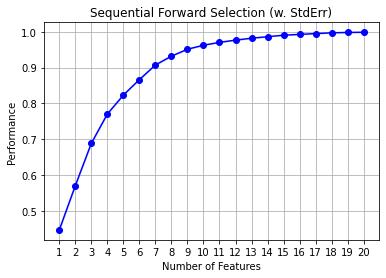

In [20]:
figLR = plot_sfs(sfsLinReg.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()


#### SVM

In [21]:
svc = svm.SVC(random_state=0, probability=True)
sfsSVC = SFS(svc, 
           k_features=20,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

In [22]:
sfsSVC.fit(fisher_features_np, labels_np,tuple(fisher_features.columns))
sfsSVC.k_feature_names_ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2518 out of 2518 | elapsed:    3.9s finished

[2020-07-11 17:29:42] Features: 1/20 -- score: 0.8541666666666666[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2517 out of 2517 | elapsed:    4.9s finished

[2020-07-11 17:29:47] Features: 2/20 -- score: 0.9166666666666666[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2516 out of 2516 | elapsed:    4.0s finished

[2020-07-11 17:29:51] Features: 3/20 -- score: 0.9583333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: 

((248, 'strength'),
 (248, 'closeness'),
 (248, 'harmonic'),
 (248, 'eigenvector'),
 (249, 'eigenvector'),
 (248, 'com_betweenness'),
 (168, 'eigenvector'),
 (117, 'current_flow_closeness'),
 (249, 'strength'),
 (248, 'subgraph'),
 (249, 'subgraph'),
 (51, 'eigenvector'),
 (197, 'load'),
 (12, 'eigenvector'),
 (299, 'com_betweenness'),
 (164, 'current_flow_closeness'),
 (163, 'eigenvector'),
 (341, 'load'),
 (228, 'load'),
 (291, 'load'))

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


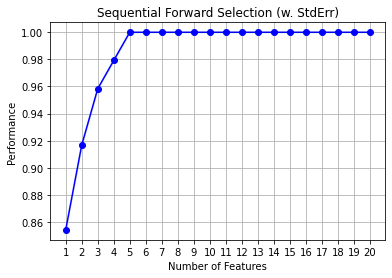

In [23]:
figSVC = plot_sfs(sfsSVC.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [24]:
pd.DataFrame.from_dict(sfsSVC.get_metric_dict())


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
feature_idx,"(8,)","(8, 429)","(8, 429, 1599)","(8, 429, 1599, 2018)","(8, 64, 429, 1599, 2018)","(8, 55, 64, 429, 1599, 2018)","(8, 23, 55, 64, 429, 1599, 2018)","(8, 23, 26, 55, 64, 429, 1599, 2018)","(1, 8, 23, 26, 55, 64, 429, 1599, 2018)","(1, 8, 23, 26, 29, 55, 64, 429, 1599, 2018)","(1, 8, 23, 26, 29, 33, 55, 64, 429, 1599, 2018)","(1, 6, 8, 23, 26, 29, 33, 55, 64, 429, 1599, 2...","(1, 6, 8, 23, 26, 27, 29, 33, 55, 64, 429, 159...","(0, 1, 6, 8, 23, 26, 27, 29, 33, 55, 64, 429, ...","(0, 1, 5, 6, 8, 23, 26, 27, 29, 33, 55, 64, 42...","(0, 1, 5, 6, 8, 10, 23, 26, 27, 29, 33, 55, 64...","(0, 1, 2, 5, 6, 8, 10, 23, 26, 27, 29, 33, 55,...","(0, 1, 2, 5, 6, 7, 8, 10, 23, 26, 27, 29, 33, ...","(0, 1, 2, 5, 6, 7, 8, 10, 13, 23, 26, 27, 29, ...","(0, 1, 2, 5, 6, 7, 8, 10, 13, 16, 23, 26, 27, ..."
cv_scores,[0.8541666666666666],[0.9166666666666666],[0.9583333333333334],[0.9791666666666666],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0],[1.0]
avg_score,0.854167,0.916667,0.958333,0.979167,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
feature_names,"((168, eigenvector),)","((168, eigenvector), (341, load))","((168, eigenvector), (341, load), (228, load))","((168, eigenvector), (341, load), (228, load),...","((168, eigenvector), (163, eigenvector), (341,...","((168, eigenvector), (164, current_flow_closen...","((168, eigenvector), (249, subgraph), (164, cu...","((168, eigenvector), (249, subgraph), (51, eig...","((248, closeness), (168, eigenvector), (249, s...","((248, closeness), (168, eigenvector), (249, s...","((248, closeness), (168, eigenvector), (249, s...","((248, closeness), (249, eigenvector), (168, e...","((248, closeness), (249, eigenvector), (168, e...","((248, strength), (248, closeness), (249, eige...","((248, strength), (248, closeness), (248, eige...","((248, strength), (248, closeness), (248, eige...","((248, strength), (248, closeness), (248, harm...","((248, strength), (248, closeness), (248, harm...","((248, strength), (248, closeness), (248, harm...","((248, strength), (248, closeness), (248, harm..."
ci_bound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std_dev,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
std_err,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### KNeighborsClassifier

In [25]:
knn = KNeighborsClassifier(n_neighbors=4)
sfsKNN = SFS(knn, 
           k_features=20,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

In [26]:
sfsKNN.fit(fisher_features_np, labels_np,tuple(fisher_features.columns))
sfsKNN.k_feature_names_ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2518 out of 2518 | elapsed:    6.2s finished

[2020-07-11 17:31:11] Features: 1/20 -- score: 0.9375[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2517 out of 2517 | elapsed:    6.2s finished

[2020-07-11 17:31:18] Features: 2/20 -- score: 0.9583333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2516 out of 2516 | elapsed:    6.3s finished

[2020-07-11 17:31:24] Features: 3/20 -- score: 0.9583333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out

((248, 'strength'),
 (248, 'closeness'),
 (248, 'harmonic'),
 (249, 'eigenvector'),
 (168, 'eigenvector'),
 (168, 'current_flow_closeness'),
 (117, 'current_flow_closeness'),
 (168, 'strength'),
 (249, 'com_betweenness'),
 (358, 'clustering_coef'),
 (248, 'subgraph'),
 (168, 'com_betweenness'),
 (249, 'subgraph'),
 (168, 'harmonic'),
 (41, 'eigenvector'),
 (91, 'eigenvector'),
 (299, 'subgraph'),
 (189, 'strength'),
 (41, 'load'),
 (311, 'pagerank'))

In [27]:
sfsKNN.subsets_

{1: {'feature_idx': (439,),
  'cv_scores': array([0.9375]),
  'avg_score': 0.9375,
  'feature_names': ((311, 'pagerank'),)},
 2: {'feature_idx': (318, 439),
  'cv_scores': array([0.95833333]),
  'avg_score': 0.9583333333333334,
  'feature_names': ((189, 'strength'), (311, 'pagerank'))},
 3: {'feature_idx': (318, 390, 439),
  'cv_scores': array([0.95833333]),
  'avg_score': 0.9583333333333334,
  'feature_names': ((189, 'strength'), (41, 'load'), (311, 'pagerank'))},
 4: {'feature_idx': (15, 318, 390, 439),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ((358, 'clustering_coef'),
   (189, 'strength'),
   (41, 'load'),
   (311, 'pagerank'))},
 5: {'feature_idx': (15, 52, 318, 390, 439),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_names': ((358, 'clustering_coef'),
   (299, 'subgraph'),
   (189, 'strength'),
   (41, 'load'),
   (311, 'pagerank'))},
 6: {'feature_idx': (0, 15, 52, 318, 390, 439),
  'cv_scores': array([1.]),
  'avg_score': 1.0,
  'feature_n

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


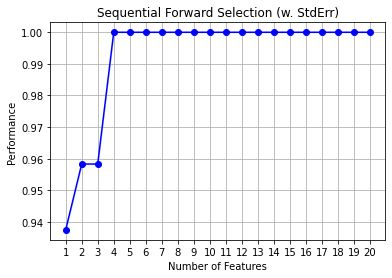

In [28]:
figKNN = plot_sfs(sfsKNN.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

#### LogisticRegression

In [29]:
LogReg = LogisticRegression(random_state=0)
sfsLogReg = SFS(LogReg, 
           k_features=(3,20),
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

In [30]:
sfsLogReg.fit(fisher_features_np, labels_np,tuple(fisher_features.columns))
sfsLogReg.k_feature_names_ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2518 out of 2518 | elapsed:    4.9s finished

[2020-07-11 17:33:24] Features: 1/20 -- score: 0.8333333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2517 out of 2517 | elapsed:    5.5s finished

[2020-07-11 17:33:30] Features: 2/20 -- score: 0.8958333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2516 out of 2516 | elapsed:    6.1s finished

[2020-07-11 17:33:36] Features: 3/20 -- score: 0.9375[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out

((248, 'harmonic'),
 (189, 'closeness'),
 (152, 'betweenness'),
 (8, 'betweenness'),
 (65, 'com_betweenness'),
 (176, 'betweenness'))

In [31]:
sfsLogReg.subsets_

{1: {'feature_idx': (2,),
  'cv_scores': array([0.83333333]),
  'avg_score': 0.8333333333333334,
  'feature_names': ((248, 'harmonic'),)},
 2: {'feature_idx': (2, 143),
  'cv_scores': array([0.89583333]),
  'avg_score': 0.8958333333333334,
  'feature_names': ((248, 'harmonic'), (152, 'betweenness'))},
 3: {'feature_idx': (2, 143, 1188),
  'cv_scores': array([0.9375]),
  'avg_score': 0.9375,
  'feature_names': ((248, 'harmonic'),
   (152, 'betweenness'),
   (176, 'betweenness'))},
 4: {'feature_idx': (2, 132, 143, 1188),
  'cv_scores': array([0.95833333]),
  'avg_score': 0.9583333333333334,
  'feature_names': ((248, 'harmonic'),
   (189, 'closeness'),
   (152, 'betweenness'),
   (176, 'betweenness'))},
 5: {'feature_idx': (2, 132, 143, 729, 1188),
  'cv_scores': array([0.97916667]),
  'avg_score': 0.9791666666666666,
  'feature_names': ((248, 'harmonic'),
   (189, 'closeness'),
   (152, 'betweenness'),
   (65, 'com_betweenness'),
   (176, 'betweenness'))},
 6: {'feature_idx': (2, 132, 1

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


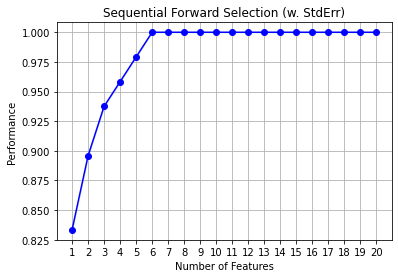

In [32]:
figKNN = plot_sfs(sfsLogReg.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

#### Ensemble

In [33]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier

In [34]:
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting='soft')

In [35]:
sfsENS = SFS(eclf, 
           k_features=20,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

In [36]:
sfsENS.fit(fisher_features_np, labels_np,tuple(fisher_features.columns))
sfsENS.k_feature_names_ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2518 out of 2518 | elapsed:  5.1min finished

[2020-07-11 17:40:52] Features: 1/20 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2517 out of 2517 | elapsed:  5.5min finished

[2020-07-11 17:46:19] Features: 2/20 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2516 out of 2516 | elapsed:  5.6min finished

[2020-07-11 17:51:55] Features: 3/20 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remain

((248, 'strength'),
 (248, 'closeness'),
 (248, 'harmonic'),
 (248, 'eigenvector'),
 (249, 'eigenvector'),
 (248, 'com_betweenness'),
 (69, 'strength'),
 (168, 'strength'),
 (358, 'clustering_coef'),
 (248, 'subgraph'),
 (299, 'eigenvector'),
 (197, 'load'),
 (268, 'strength'),
 (86, 'harmonic'),
 (83, 'strength'),
 (51, 'current_flow_closeness'),
 (241, 'load'),
 (189, 'harmonic'),
 (275, 'current_flow_closeness'),
 (189, 'current_flow_closeness'))

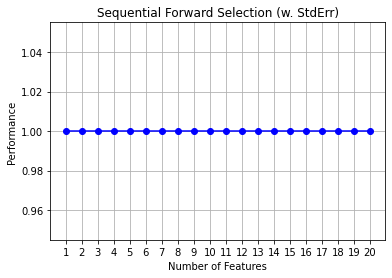

In [41]:
figENS = plot_sfs(sfsENS.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

### Save Data

In [42]:
thresholding_method = 'GCE' # It could be 'GCE' or 'user_defined'
denoising_strategy = 'corr36p' 
normalized_local_measures = 'True'

In [44]:
bb = pd.DataFrame.from_dict(sfsLinReg.get_metric_dict()).T.feature_names.to_list()[-1]

In [45]:
b20f = [i[0] for i in list(bb)]

In [49]:
fsfs_features = fisher_features.iloc[:,list(b20f)]
fsfs_features.to_csv(rootdir + '/data/08_features/fsisher_fsf/fsisher_fsf_features.csv')
labels.to_csv(rootdir + '/data/08_features/fsisher_fsf/targets.csv')